# Binomial Distribution, Bernoulli distribution, Negative Binomial Distribution.

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import nbinom

n, p = 15, 0.5
mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
x = np.arange(nbinom.ppf(0.01, n, p),
              nbinom.ppf(0.99, n, p))

In [63]:
x.var()

52.0

In [59]:
x.mean()

17.0

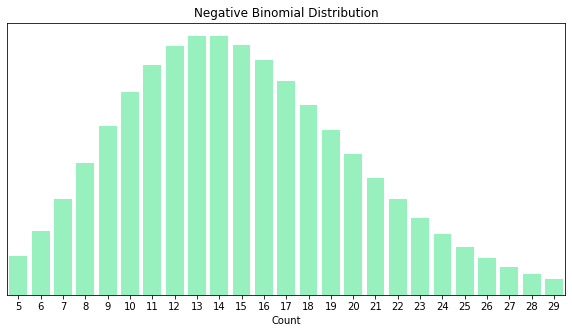

In [56]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

sns.barplot(x=x.astype(int), y=nbinom.pmf(x, n, p), color='#17FF7D', alpha=0.5, ax=ax)
ax.set_title('Negative Binomial Distribution')
ax.set_xlabel('Count')
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='y', which='both', length=0)
ax.set_ylabel('')
plt.savefig('./NegativeBinomialDistribution.png', dpi=300, facecolor='w', bbox_inches = "tight");

In [188]:
import statsmodels.api as sm

data = sm.datasets.fair.load().data
data = sm.add_constant(data, prepend=False)

In [134]:
print('Mean count of children per marriage: ', data['children'].mean())
print('Variance of the count of children per marriage: ', data['children'].var())

Mean count of children per marriage:  1.3968740182218033
Variance of the count of children per marriage:  2.054838616333698


''

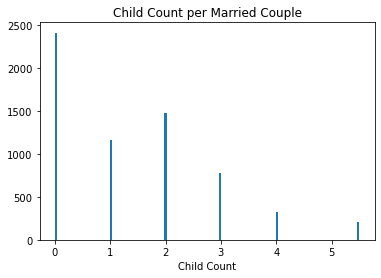

In [165]:
plt.hist(data['children'], bins=150)
plt.xlabel('Child Count')
plt.title('Child Count per Married Couple')
plt.savefig('./ChildrenDistribution.png', dpi=300, facecolor='w', bbox_inches = "tight");
;

Here we use the log-likelihood method 'nb2', which is the variance derived from the mixture of Poisson distributions with Gamma mixing weights.

In [319]:
y = round(data['children'])
X = data[['const','age','religious','yrs_married','educ','occupation','occupation_husb','affairs','rate_marriage']] 

In [320]:
import pandas as pd

pd.concat([X, y], axis=1).head().to_clipboard()

In [321]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

Here we have overdisperison of our target variable, which means we should use negative binomial regression instead of Poisson regression. Although it does not apply in this situation, it is useful to note that with negative binomial regression, target value order does not matter as it does with Poisson regression.

In [192]:
np.unique(y)

array([0., 1., 2., 3., 4., 6.])

''

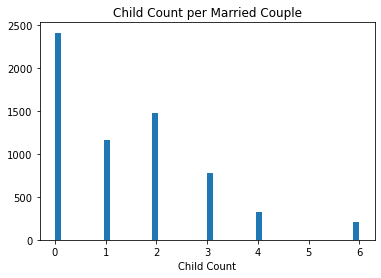

In [193]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50)
plt.xlabel('Child Count')
plt.title('Child Count per Married Couple')
plt.savefig('./ChildrenDistribution.png', dpi=300, facecolor='w', bbox_inches = "tight");
;

In [312]:
df_train = pd.concat([X_train,y_train], axis=1)

In [357]:
import statsmodels.formula.api as smf
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
df_train['y_lambda'] = poisson_training_results.mu

df_train['y_auxiliary'] = df_train.apply(lambda x: ((x['children'] - x['y_lambda'])**2 - x['y_lambda']) / x['y_lambda'], axis=1)

aux_olsr_results = smf.ols('y_auxiliary ~ y_lambda - 1', df_train).fit()
print(aux_olsr_results.params)

y_lambda    0.670327
dtype: float64


In [359]:
np.shape(poisson_training_results.mu)

(4774,)

In [361]:
np.shape(y_train)

(4774,)

In [363]:
import statsmodels.formula.api as smf
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

df_aux = pd.DataFrame({'children':y_train,
                       'y_lambda':poisson_training_results.mu})

df_train['y_lambda'] = poisson_training_results.mu

df_train['y_auxiliary'] = df_train.apply(lambda x: ((x['children'] - x['y_lambda'])**2 - x['y_lambda']) / x['y_lambda'], axis=1)

aux_olsr_results = smf.ols('y_auxiliary ~ y_lambda - 1', df_train).fit()
print(aux_olsr_results.params)

y_lambda    0.670327
dtype: float64


In [384]:
from statsmodels.formula.api import ols as OLS
import statsmodels.api as sm

poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

df_aux = pd.DataFrame()
df_aux['y_mu_hat'] = poisson_model.mu
df_aux['children'] = y_train
df_aux['y_auxiliary'] = df_aux.apply(lambda x: ((x['children'] - x['y_mu_hat'])**2 - x['y_mu_hat']) / x['y_mu_hat'], axis=1)

ols_model = OLS('y_auxiliary ~ y_mu_hat - 1', df_aux).fit()
print(ols_model.params)

y_mu_hat    0.622034
dtype: float64


In [386]:
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:            y_auxiliary   R-squared (uncentered):                   0.021
Model:                            OLS   Adj. R-squared (uncentered):              0.021
Method:                 Least Squares   F-statistic:                              78.45
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                    1.26e-18
Time:                        17:21:30   Log-Likelihood:                         -12448.
No. Observations:                3589   AIC:                                  2.490e+04
Df Residuals:                    3588   BIC:                                  2.490e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [400]:
from statsmodels.genmod.families.family import NegativeBinomial

negative_binomial_model = sm.GLM(y_train, X_train, family=NegativeBinomial(alpha=ols_model.params.values)).fit()
print(negative_binomial_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               children   No. Observations:                 4774
Model:                            GLM   Df Residuals:                     4765
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6608.4
Date:                Sun, 20 Nov 2022   Deviance:                       2850.6
Time:                        17:41:53   Pearson chi2:                 2.46e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3689
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0784      0.183     

In [405]:
from sklearn.metrics import mean_squared_error as RMSE

print('Training Root Mean Squared Error: ', RMSE(y_train, negative_binomial_model.predict(X_train)) )
print('Testing Root Mean Squared Error: ', RMSE(y_test, negative_binomial_model.predict(X_test)))

Training Root Mean Squared Error:  1.2553439918425695
Testing Root Mean Squared Error:  1.266620561303553
